In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report

加载数据集

In [2]:
data = sio.loadmat('D:\机器学习——Andrew_rag\code\ex3-neural network\ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
x = data['X']
y = data['y']

print(np.unique(y))

print(x.shape)
print(y.shape)

[ 1  2  3  4  5  6  7  8  9 10]
(5000, 400)
(5000, 1)


数据转换，原数据为倒置

In [4]:
def transpose(x):
    x = np.array([im.reshape((20,20)).T for im in x])#一个转置来获得正确的方向

    x = np.array([im.reshape(400) for im in x])#再次将图像展平以保留矢量表示
    return x

x = transpose(x)
print(x.shape)

(5000, 400)


数据可视化

In [5]:
def plot_one(image):
    fig, ax = plt.subplots(figsize=(1,1))
    #矩阵可视化，plot a matrix or an array as an image
    ax.matshow(image.reshape((20,20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))#去除刻标
    plt.yticks(np.array([]))

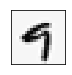

this should be 


In [6]:
pick_one = np.random.randint(0,5000)
plot_one(x[pick_one,:])
plt.show()
print('this should be '.format(y[pick_one]))

np.random.choice(arr,size=None,replace=True,p=None)

arr: 一维数组或int型变量。若是数组就按照数组中的数据进行采样，若是int型变量，相当于np.arange(a)。
size：int型变量或者 tuple of ints 决定输出的shape。如果给定的是(m,n,k),那么m*n*k个采样点将会被采样。
replace：采样是否放回，即决定采样中是否有重复值
p：一维数组，对应arr数组中每个采样点的概率分布，即每个采样点以多大的概率被采样。没有给出则使用标准分布，每个采样点等概率被采样

In [7]:
def plot_100(x):
    size = int(np.sqrt(x.shape[1]))
    #在x中的5000行的5000这个数字中随机采样100个数字（即第几行的几
    sample_idx = np.random.choice(x.shape[0],100)
    #存放随机采样的100行照片
    sample_images = x[sample_idx,:]

    #nrows、ncols控制子图网格的行列数：10*10
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8,8))

    for r in range(10):
        for c in range(10):
            ax_array[r,c].matshow(sample_images[10 * r + c].reshape((size,size)), 
                                  cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

<function matplotlib.pyplot.show(close=None, block=None)>

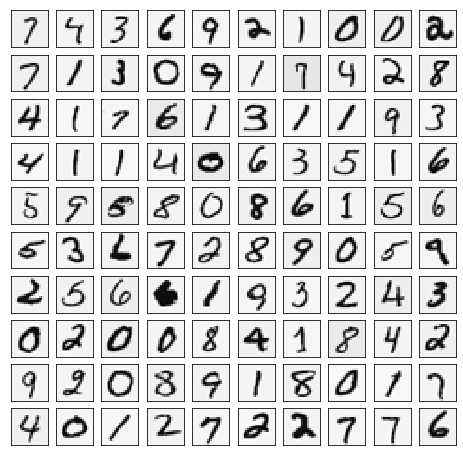

In [8]:
plot_100(x)
plt.show

In [9]:
data2 = sio.loadmat('D:\机器学习——Andrew_rag\code\ex3-neural network\ex3data1.mat')
raw_x = data2['X']
raw_y = data2['y']

print(raw_x.shape)
print(raw_y)

(5000, 400)
[[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]


In [10]:
raw_y = raw_y.reshape(raw_y.shape[0])#后续出来才会是[1,1,1,……,0],而不是[[1],[1],[1],……,[0]]
print(raw_y)
print(raw_y.shape)

[10 10 10 ...  9  9  9]
(5000,)


In [11]:
x = np.insert(raw_x, 0,values=np.ones(raw_x.shape[0]), axis=1)

y_matrix = []
for k in range(1,11):
    y_matrix.append((raw_y == k).astype(int))
#最后一列k=10，都是0，把最后一列放到第一列
y_matrix = [y_matrix[-1]] + y_matrix[:-1]
y = np.array(y_matrix)

y

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

# 训练一维模型

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
def cost(theta,x,y):
    return np.mean(-y * np.log(sigmoid(x @ theta)) - (1 - y) * np.log(1 - sigmoid(x @ theta)))

In [14]:
def regularized_cost(theta, x, y):
    theta_jn = theta[1:]
    regularized_term = (1 / (2 * len(x))) * np.power(theta_jn,2).sum()

    return cost(theta, x, y) + regularized_term

In [15]:
def gradient(theta, x, y):
    return (1 / len(x)) * x.T @ (sigmoid(x @ theta) - y)

In [16]:
def regularized_gradient(theta, x, y):
    theta_jn = theta[1:]
    regularized_theta = (1 / len(x)) * theta_jn
    #保证不对θ_0做正则化
    regurlarized_term = np.concatenate([np.array([0]), regularized_theta])#数组拼接，默认axis=0

    return gradient(theta, x, y) + regurlarized_term

In [17]:
def regularized_logist_reg(x, y):
    theta = np.zeros(x.shape[1])

    res = opt.minimize(fun=regularized_cost,x0=theta, args=(x,y),method='TNC',
                        jac=regularized_gradient,options={'disp': True})
    
    final_theta =res.x

    return final_theta

In [18]:
def predict(x,theta):
    prob = sigmoid(x @ theta)
    return (prob>=0.5).astype(int)

In [19]:
t0 = regularized_logist_reg(x,y[0])#训练第一个标签“10”（前面已经将10放到前面所以索引是[0]），数字0映射为标签10
print(t0.shape)
y_pred = predict(x,t0)
print('Accuracy={}'.format(np.mean(y[0] == y_pred)))

(401,)
Accuracy=0.9974


# 训练k维模型

In [20]:
k_theta = np.array([regularized_logist_reg(x,y[k]) for k in range(10)])
k_theta.shape

(10, 401)

In [21]:
prob_matrix = sigmoid(x @ k_theta.T)
np.set_printoptions(suppress=True)#设置输出格式，是否为科学计数法输出
prob_matrix

array([[0.99577332, 0.        , 0.00053486, ..., 0.00006466, 0.0000391 ,
        0.00172254],
       [0.99834661, 0.0000001 , 0.00005604, ..., 0.00009681, 0.0000029 ,
        0.00008484],
       [0.99139726, 0.        , 0.00056821, ..., 0.00000655, 0.02653731,
        0.00197605],
       ...,
       [0.00000068, 0.04143183, 0.00320881, ..., 0.00012722, 0.00297214,
        0.70755731],
       [0.00001842, 0.00000013, 0.00000009, ..., 0.00164821, 0.0681796 ,
        0.86119029],
       [0.02879094, 0.        , 0.00012974, ..., 0.36613286, 0.0049738 ,
        0.14834297]])

In [22]:
y_pred = np.argmax(prob_matrix, axis=1)#取出最大值行的索引
y_pred

array([0, 0, 0, ..., 9, 9, 7], dtype=int64)

In [23]:
y_answer = raw_y.copy()
y_answer[y_answer==10] = 0
print(classification_report(y_answer, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# 神经网络模型训练

In [24]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [25]:
theta1, theta2 = load_weight('D:\机器学习——Andrew_rag\code\ex3-neural network\ex3weights.mat')

theta1.shape, theta2.shape

((25, 401), (10, 26))

在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，需要使用原始数据（不转置)

In [31]:
data3 = sio.loadmat('D:\机器学习——Andrew_rag\code\ex3-neural network\ex3data1.mat')
x3 = data3['X']
y3 = data3['y']
x3 = np.insert(x3,0, values=np.ones(x3.shape[0]),axis=1)
x3.shape, y3.shape

((5000, 401), (5000, 1))

前馈预测

In [32]:
a1 = x3
z2 = a1 @ theta1.T
z2.shape

(5000, 25)

In [33]:
z2 = np.insert(z2,0, values=np.ones(z2.shape[0]),axis=1)
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [34]:
z3 = a2 @ theta2.T
a3 = sigmoid(z3)
a3

array([[0.00013825, 0.0020554 , 0.00304012, ..., 0.00049102, 0.00774326,
        0.99622946],
       [0.00058776, 0.00285027, 0.00414688, ..., 0.00292311, 0.00235617,
        0.99619667],
       [0.00010868, 0.0038266 , 0.03058551, ..., 0.07514539, 0.0065704 ,
        0.93586278],
       ...,
       [0.06278247, 0.00450406, 0.03545109, ..., 0.0026367 , 0.68944816,
        0.00002744],
       [0.00101909, 0.00073436, 0.00037856, ..., 0.01456166, 0.97598976,
        0.00023337],
       [0.00005908, 0.00054172, 0.0000259 , ..., 0.00700508, 0.73281465,
        0.09166961]])

In [37]:
y_pred = np.argmax(a3, axis=1) + 1
print(classification_report(y3, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

